# Residual concentrations

In [3]:
import numpy as np
from lucifex.solver import OptionsPETSc
from lucifex.fdm import AB, CN
from lucifex.sim import run, Simulation
from lucifex.viz import plot_colormap, plot_line
from crocodil.dns import dns_system_a, SYSTEM_A_REFERENCE

STORE = 1
NX = 80
NY = 80

def create_simulation(
    Da: float,
    cr: float,
):
    physical = dict(SYSTEM_A_REFERENCE)
    physical.update(cr=cr, Da=Da)
    return dns_system_a(
        store_delta=STORE, 
    )(
        Nx=NX,
        Ny=NY,
        scaling='advective',
        **physical,
        D_adv=AB(1)@CN,
        D_diff=AB(1)@CN,
        dt_max=0.1,
        cfl_courant=0.5,
        c_stabilization=None,
        c_limits=None,
        c_petsc=OptionsPETSc('gmres', 'ilu'),
        flow_petsc=(OptionsPETSc('cg', 'hypre'), None),
        diagnostic=True,
    )


cr_opts = (0.0, 1.0)
Da_opts = (10, 100.0)
simulations: dict[tuple[float, float], Simulation] = {}

for Da in Da_opts:
    for cr in cr_opts:
        simulations[(Da, cr)] = create_simulation(Da, cr)

n_stop = 300
t_stop = 20.0
dt_init = 1e-6
n_init = 10
for Da in Da_opts:
    for cr in cr_opts:
        sim = simulations[(Da, cr)]
        run(sim, n_stop, t_stop, dt_init=dt_init, n_init=n_init)

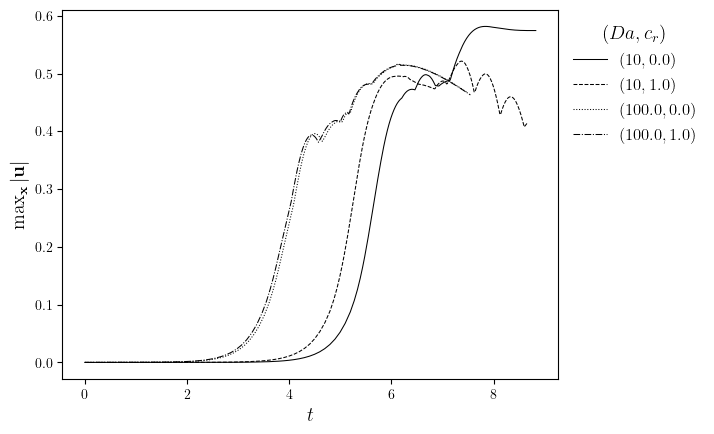

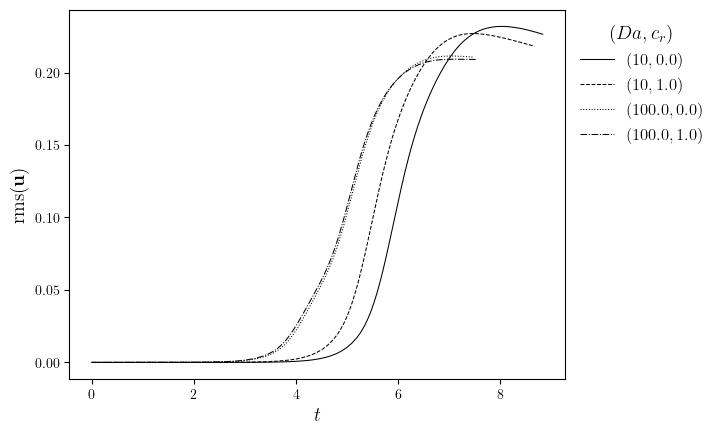

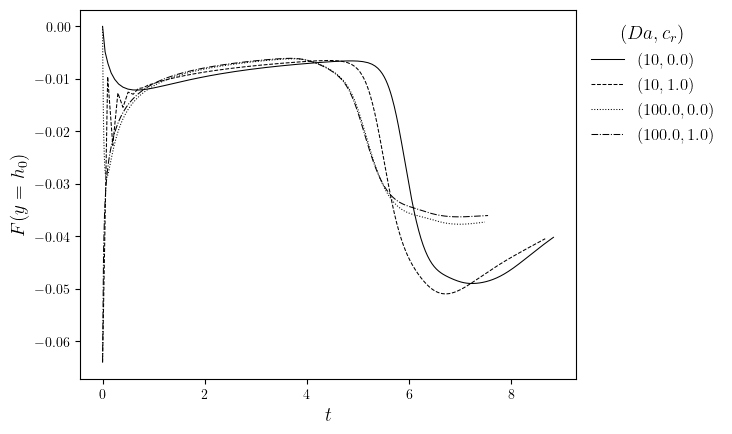

In [4]:
uMax_lines, uRMS_lines, f_lines, labels = [], [], [], []
legend_title = f'$(Da, c_r)$'

for Da in Da_opts:
    for cr in cr_opts:
        label = f'$({Da}, {cr})$'
        labels.append(label)
        sim = simulations[(Da, cr)]
        f = sim['f']
        f, fPlus, fMinus = f.split()
        f_lines.append((f.time_series, [np.sum(i) for i in f.value_series]))
        uMinMax = sim['uMinMax']
        uMax = uMinMax.sub(1)
        uMax_lines.append((uMax.time_series, uMax.value_series))
        uRMS = sim['uRMS']
        uRMS_lines.append((uRMS.time_series, uRMS.value_series))

fig, ax = plot_line(
    uMax_lines,
    cyc='black',
    x_label='$t$',
    y_label='$\max_{\mathbf{x}}|\mathbf{u}|$',
    legend_labels=labels,
    legend_title=legend_title,
)
fig, ax = plot_line(
    uRMS_lines,
    x_label='$t$',
    y_label='$\mathrm{rms}(\mathbf{u})$',
    legend_labels=labels,
    legend_title=legend_title,
)
fig, ax = plot_line(
    f_lines,
    cyc='black',
    x_label='$t$',
    y_label='$F(y=h_0)$',
    legend_labels=labels,
    legend_title=legend_title,
)

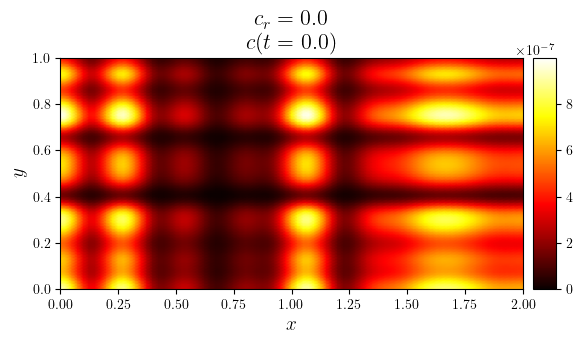

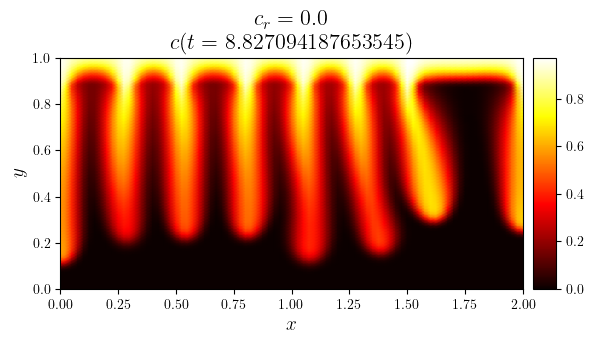

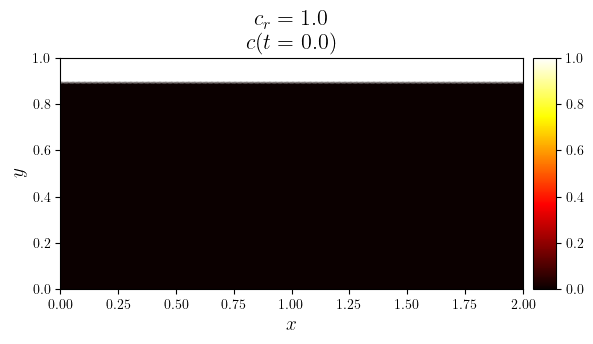

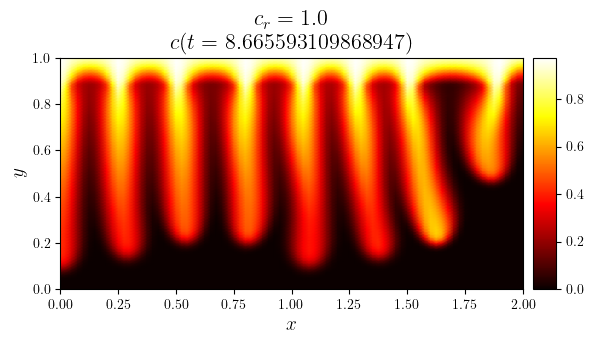

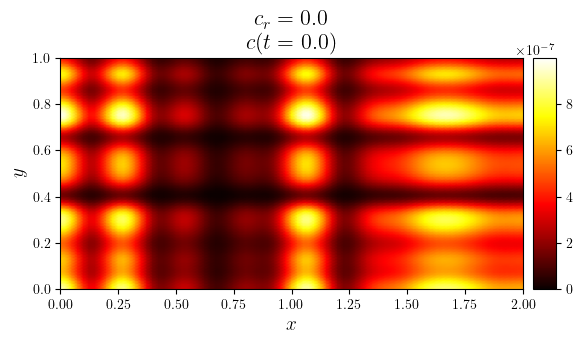

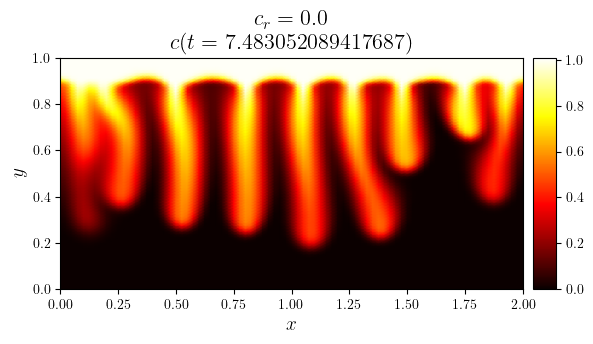

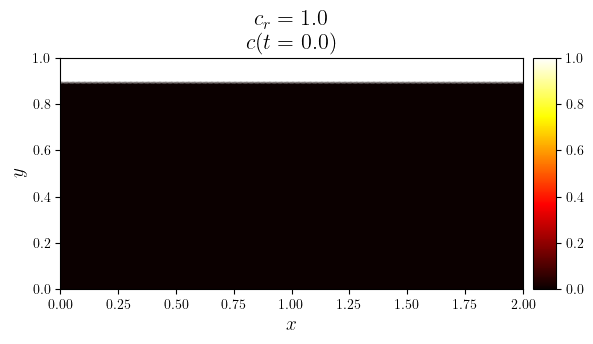

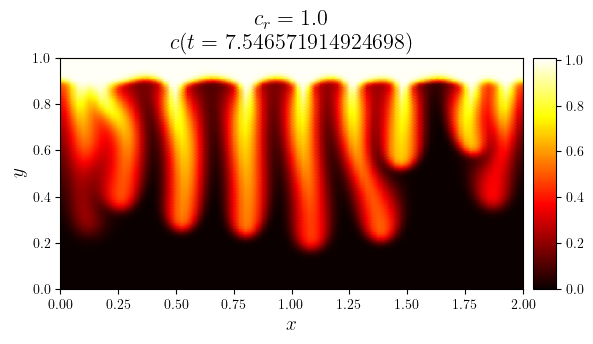

: 

In [ ]:
time_indices = (0, -1)
for Da in Da_opts:
    for cr in cr_opts:
        sim = simulations[(Da, cr)]
        c = sim['c']
        for i in time_indices:
            fig, ax = plot_colormap(
                c.series[i], 
                title=f'$c_r={cr}$\n$c(t={c.time_series[i]})$',
            )